# Ateísmo e COVID-19: Países menos religiosos respondem melhor? - Um estudo preliminar


Que as religiões trazem conforto e estão ligadas a ações sociais nas mais diversas formas é inegável.


Entretanto, frequentemente as atividades religiosas são acompanhadas por dogmas, que em casos colidem (direta ou indiretamente) com os estudos lógico-científicos. 

Será que, então, nações com populações menos religiosas reagiriam diferente ao COVID-19?


O trabalho visa avaliar brevemente as diferenças na resposta a COVID-19 levando em consideração essa variável.


Dados de irreligião e testagem por milhão de habitantes foram obtidos das páginas Wikipédia abaixo. 
* Dados sobre religião: https://en.wikipedia.org/w/index.php?title=List_of_countries_by_irreligion&oldid=946799645 (25/04/2020)
* Dados sobre testagem para COVID-19 https://en.wikipedia.org/w/index.php?title=COVID-19_testing&oldid=952911161#Virus_testing_statistics_by_country (25/04/2020)



In [67]:
import pandas as pd



irreligion_article_url = "https://en.wikipedia.org/w/index.php?title=List_of_countries_by_irreligion&oldid=946799645"
tables_in_irreligion_article = pd.read_html(irreligion_article_url)
tables_in_irreligion_article[0].to_csv('irreligion_wikipedia_table.txt',  sep = ";")

irreligion_by_country = irreligion_by_country[["Country or region", "WIN/GIA (2017)[7]"	]]
irreligion_by_country.columns = ["country", "irreligion_proportion"]



In [71]:


covid_testing_url = "https://en.wikipedia.org/w/index.php?title=COVID-19_testing&oldid=952911161#Virus_testing_statistics_by_country"
tables_in_testing_article = pd.read_html(covid_testing_url)
tables_in_testing_article[2].to_csv('covid_testing_wikipedia_table.txt',  sep = ";")

tests_per_million_by_country = tables_in_testing_article[2]
tests_per_million_by_country = tests_per_million_by_country[["Country", "Tested /millionpeople"]]
tests_per_million_by_country.columns = ["country", "tests_per_million"]



In [72]:
tests_per_million_by_country

,country,tests_per_million
0,Albania,2542
1,Argentina,1051
2,Armenia,6075
3,Australia,19939
4,Austria,25569
...,...,...
82,United States,15811
83,Uruguay,4563
84,Venezuela[c],13644
85,Vietnam,2149


In [73]:
import re

tests_per_million_by_country["country"] = [re.sub(r"\[.\]", "", country).strip() for country in tests_per_million_by_country["country"]]
tests_per_million_by_country

/home/lubianat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,country,tests_per_million
0,Albania,2542
1,Argentina,1051
2,Armenia,6075
3,Australia,19939
4,Austria,25569
...,...,...
82,United States,15811
83,Uruguay,4563
84,Venezuela,13644
85,Vietnam,2149


In [86]:
import re

irreligion_by_country["country"] = [re.sub(r" \(details\)", "", country).strip() for country in irreligion_by_country["country"]]
irreligion_by_country

/home/lubianat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,country,irreligion_proportion
0,Afghanistan,NaN
1,Albania,39%
2,Argentina,34%
3,Armenia,6%
4,Australia,63%
...,...,...
94,United States,39%
95,Uruguay,NaN
96,Uzbekistan,NaN
97,Venezuela,NaN


In [108]:
import numpy as np



irreligion_and_tests_df = irreligion_by_country.merge(tests_per_million_by_country, on = 'country')
print(irreligion_and_tests_df.head())


     country irreligion_proportion tests_per_million
0    Albania                   39%              2542
1  Argentina                   34%              1051
2    Armenia                    6%              6075
3  Australia                   63%             19939
4    Austria                   53%             25569


In [109]:
irreligion_and_tests_df = irreligion_and_tests_df[irreligion_and_tests_df["irreligion_proportion"] != " "]
irreligion_and_tests_df = irreligion_and_tests_df.dropna(axis = "rows")

In [110]:
irreligion_and_tests_df.head(1)

,country,irreligion_proportion,tests_per_million
0,Albania,39%,2542


In [117]:
def get_proportion(percentage_string):
    number_to_be_divided = float(percentage_string.strip("%"))
    proportion = number_to_be_divided/100
    return(proportion)


irreligion_and_tests_df["irreligion_proportion"] = irreligion_and_tests_df["irreligion_proportion"].map(get_proportion)



0     True
1     True
2     True
3     True
4     True
5     True
6     True
8     True
9     True
10    True
11    True
12    True
14    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
33    True
35    True
36    True
40    True
43    True
45    True
46    True
47    True
48    True
49    True
50    True
51    True
52    True
53    True
54    True
55    True
58    True
60    True
61    True
62    True
65    True
67    True
68    True
69    True
72    True
Name: irreligion_proportion, dtype: bool

In [98]:
irreligion_and_tests_df["tests_per_million"] = [int(test_number.replace(",", "")) for test_number in irreligion_and_tests_df["tests_per_million"] ]

[Text(0, 0.5, 'Testes por milhão de habitantes'),
 Text(0.5, 0, 'Proporção de pessoas não religiosas')]

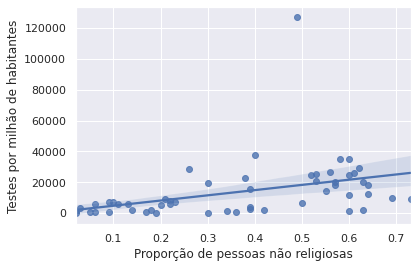

In [99]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


ax = sns.regplot(x="irreligion_proportion", y="tests_per_million", data=irreligion_and_tests_df)
ax.set(xlabel='Proporção de pessoas não religiosas', ylabel='Testes por milhão de habitantes')

In [100]:
len(irreligion_and_tests_df["tests_per_million"])

irreligion_and_tests_df["country"][irreligion_and_tests_df["tests_per_million"] == 126204]

# O país com mais testes é a islândia, que tem uma população pequena e testa muito

Series([], Name: country, dtype: object)

In [101]:
from scipy.stats import spearmanr

spearmanr(irreligion_and_tests_df["irreligion_proportion"], irreligion_and_tests_df["tests_per_million"])

SpearmanrResult(correlation=0.5930019796961882, pvalue=2.8845246370413708e-06)

# Breve discussão e conclusão do trabalho:

Com uma correlação positiva moderada de 0.59 e um valor p de menos 0,000001, dá para afirmar que há uma correlação entre irreligiosidade e intensidade da resposta ao COVID-19. 

O valor p indica, grosso modo, a proporção de vezes que você veria uma correlação de 0.59 ou maior se os valores fossem aleatórios para as duas coisas comparadas. 

Correlação não siginifca, causalidade, entretanto, e este é apenas um resultado preliminar. 

O resultado observado indica que o tema vale ser explorado com maior profundidade para compreender melhor as respostas nacionais à pandemia. 